In [1]:
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit


In [2]:
import pandas as pd
import numpy as np
from sympy import Symbol,expand

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [3]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
path = 'E:/individus_filtered'

In [54]:
# Method from 'A Supervised Machine Learning Approach to Classify the Acoustic Behaviour of Marine Mammals' by M. C. L. de Jong et al. (2023)
def calculate_and_add_slope(df, freq1, freq2):
    slope_column_name = f"slope_{freq1}_{freq2}"
    spl1 = df[f'upwards_mean_{freq1}']
    spl2 = df[f'upwards_mean_{freq2}']
    delta_spl = spl2 - spl1
    delta_log_freq = np.log10(freq2) - np.log10(freq1)
    slope = delta_spl / delta_log_freq
    df[slope_column_name] = slope 
    return df

def classify_rain(df, offset = 4, optimised_tresh=False):
    combinations = [("upwards_mean_5000","upwards_mean_15000"),("upwards_mean_8000","upwards_mean_15000"),("upwards_mean_8000","slope_8000_15000")]
    coefs = []
    for comb in combinations:

        polydeg = 1
        quant_val = 0.8

        quantile_df = pd.DataFrame({})
        for bin in range(-55, -25, 5):
            _df = df[(df[comb[0]] > bin) & (df[comb[0]] < bin + 5)]
            threshold = _df[comb[1]].quantile(quant_val)
            _df.loc[_df[comb[1]] > threshold, comb[1]] = np.nan
            _df = _df.dropna(subset=[comb[0], comb[1]])
            quantile_df = pd.concat([quantile_df, _df])

        model = np.poly1d(np.polyfit(quantile_df[comb[0]], quantile_df[comb[1]], polydeg))
        x_Symb = Symbol(comb[1])

        x_vals = np.linspace(df[comb[1]].min(), df[comb[1]].max(), 100)
        y_vals = model(x_vals)
        
        a, b = model.coefficients
        coefs.append((comb[0], comb[1], a, b))

    if optimised_tresh:
        conditions = [
            (df[coefs[0][1]]>coefs[0][2]*df[coefs[0][0]] +coefs[0][3]+offset/2) & 
            (df[coefs[1][1]]>coefs[1][2]*df[coefs[1][0]] +coefs[1][3]+offset) & 
            (df[coefs[2][1]]>coefs[2][2]*df[coefs[2][0]] +coefs[2][3]+offset/4) 
        ]
    else :
        conditions = [
            (df[coefs[0][1]]>coefs[0][2]*df[coefs[0][0]] +coefs[0][3]+offset) & 
            (df[coefs[1][1]]>coefs[1][2]*df[coefs[1][0]] +coefs[1][3]+offset) & 
            (df[coefs[2][1]]>coefs[2][2]*df[coefs[2][0]] +coefs[2][3]+offset) 
        ]

    choices = ["R"]
    df["Rain_Type_preds"] = np.select(conditions, choices, default="N+WR")

    conditions = [
        (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < 7)
    ]
    choices = ["R"]
    df["Rain_Type"] = np.select(conditions, choices, default="N+WR")
    return df

def create_df(path):
    df = pd.read_csv(path)
    df = calculate_and_add_slope(df, freq1=2000, freq2=8000)
    df = calculate_and_add_slope(df, freq1=8000, freq2=15000)
    wind_tresh = 7
    conditions = [
        (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < wind_tresh),
        # (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] >= wind_tresh),
        # (df["precipitation_GPM"] <= 0.1) & (df["wind_speed"] >= 7)
    ]
    choices = ["R"]#, "WR"]#, "W"]
    df["weather"] = np.select(conditions, choices, default="N+WR")

    df = df.dropna(subset=["precipitation_GPM","upwards_mean_5000","upwards_mean_8000","upwards_mean_15000","slope_2000_8000","slope_8000_15000"])
    return df

In [105]:
df = pd.DataFrame({})
for depid in depids :
    df = pd.concat([df,create_df(os.path.join(path, depid, f"{depid}_dive.csv"))], ignore_index=True)
df = classify_rain(df, offset=1.25, optimised_tresh=True)

In [106]:
df_r = df[df["precipitation_GPM"]>0.1].copy()

# df_r = df[df["Rain_Type_preds"]=="R"].copy()
# df_r = df.copy()
train_df, test_df = train_test_split(
    df_r, test_size=0.7, random_state=42, stratify=df_r["precipitation_GPM"]>0.1)

In [107]:
freq = 5000
gt = 'precipitation_GPM'

def logarithmic(x,a,b):
    return 10**((x+a)/b)

def lin_kknoufal(x, a, b, c, d):
    return (x + (np.log(8000) - np.log(5000)*a + b))/((np.log(85000) - np.log(5000)*c + d))

popt, popv = curve_fit(logarithmic, train_df[f"upwards_mean_{freq}"], 
                      train_df[gt], maxfev=25000, bounds=((0,0),(100,100)), method = 'trf')

estimation = logarithmic(test_df[f"upwards_mean_{freq}"], *popt)
mae = metrics.mean_absolute_error(test_df[gt], estimation)
rmse = metrics.root_mean_squared_error(test_df[gt], estimation)
r2 = metrics.r2_score(test_df[gt], estimation)
var = np.var(abs(test_df[gt])-abs(estimation))
std = np.std(abs(test_df[gt])-abs(estimation))

mae : 0.6978558605723885
rmse : 1.2738264227669485
r2 : -0.012928599733557755
var : 1.6199582359386853
std : 1.2727757995572846


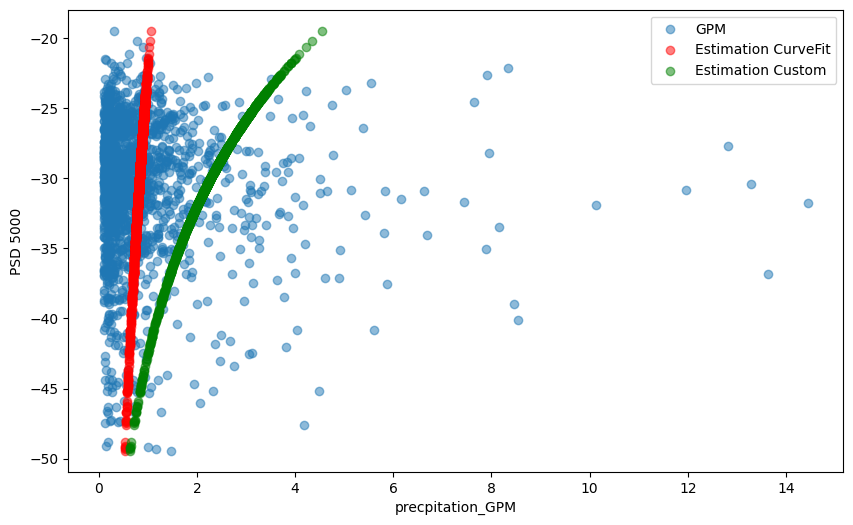

In [110]:
print(f"mae : {mae}")
print(f"rmse : {rmse}")
print(f"r2 : {r2}")
print(f"var : {var}")
print(f"std : {std}")

plt.figure(figsize=(10, 6))
plt.scatter(test_df["precipitation_GPM"], test_df[f"upwards_mean_{freq}"], label="GPM", alpha=0.5)
# plt.scatter(test_df["tp"]*1000, test_df[f"upwards_mean_{freq}"], label="ERA5", alpha=0.5)

plt.scatter(estimation, test_df[f"upwards_mean_{freq}"], label="Estimation CurveFit", color='red', alpha=0.5)
plt.scatter(10**((test_df[f"upwards_mean_{freq}"]+42.5)/35), test_df[f"upwards_mean_{freq}"], label="Estimation Custom", color='green', alpha=0.5)

plt.xlabel('precpitation_GPM')
plt.ylabel(f"PSD {freq}")
plt.legend()

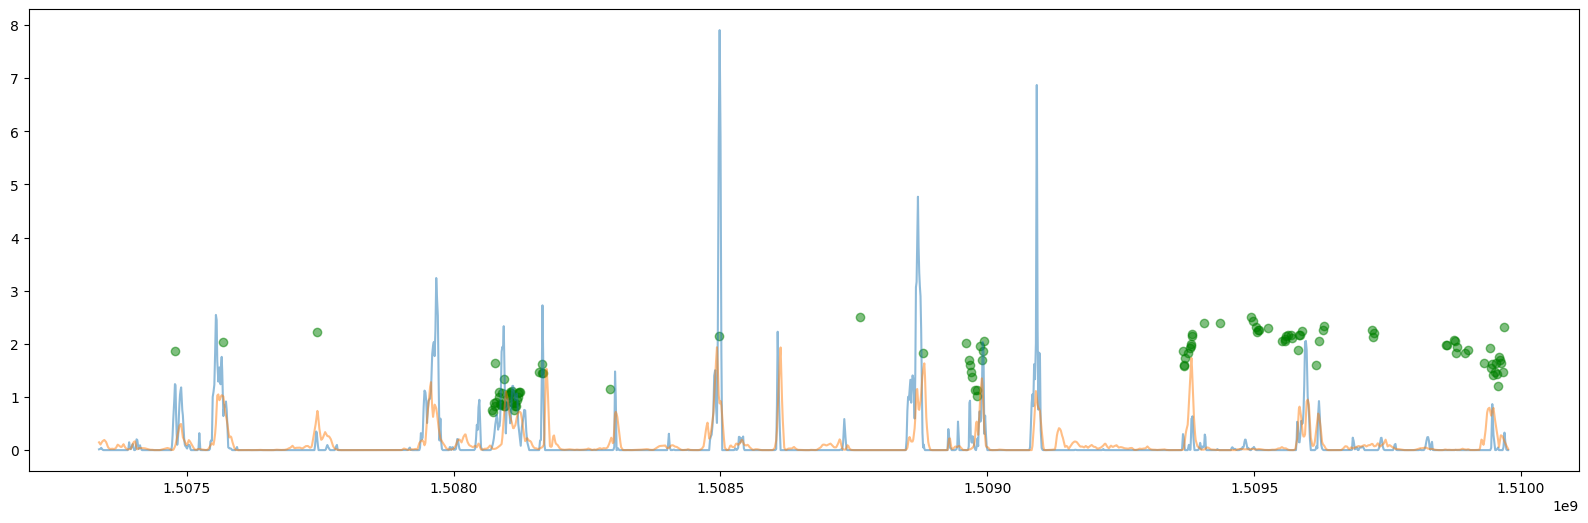

In [145]:
plt.figure(figsize=(20, 6))
plt.plot(df["begin_time"], df["precipitation_GPM"], label="GPM", alpha=0.5)
plt.plot(df["begin_time"], df["tp"]*1000, label="ERA5", alpha=0.5)
plt.scatter(df_r["begin_time"], 10**((df_r[f"upwards_mean_{freq}"]+42.5)/35), label=f"Upwards Mean {freq} Hz", alpha=0.5, color="green")

In [146]:
gpm_sum = [0]
era_sum = [0]
estimation = [0]
for row, index in df.iterrows():
    gpm_sum.append(df["precipitation_GPM"].loc[row]+ gpm_sum[-1])
    era_sum.append(df["tp"].loc[row]*1000 + era_sum[-1])
    estimation.append(10**((df[f"upwards_mean_{freq}"].loc[row]+15)/30) + estimation[-1])
gpm_sum.pop(0)
era_sum.pop(0)
estimation.pop(0)

0

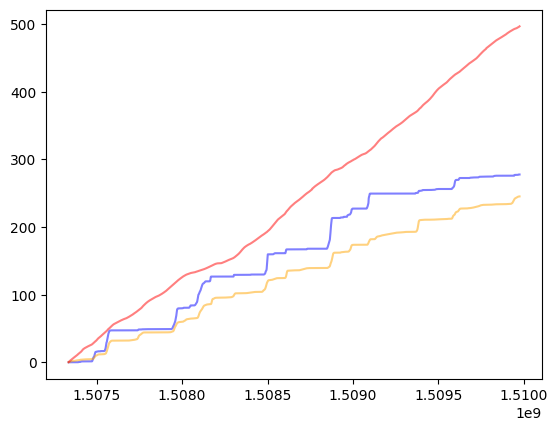

In [147]:
plt.plot(df["begin_time"], gpm_sum, label="GPM Cumulative", color='blue', alpha=0.5)
plt.plot(df["begin_time"], era_sum, label="ERA5 Cumulative", color='orange', alpha=0.5)
plt.plot(df["begin_time"], estimation, label=f"Estimation Cumulative {freq} Hz", color='red', alpha=0.5)

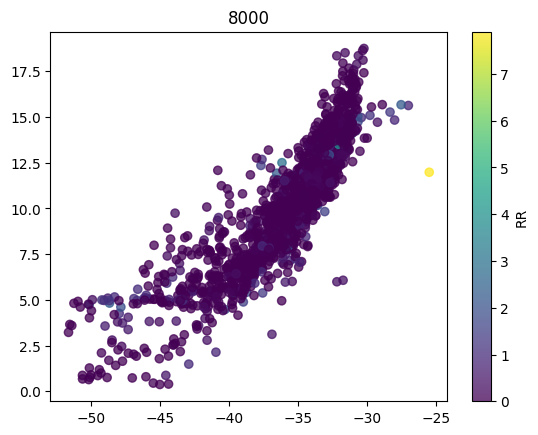

In [32]:
freqs = [500, 1000, 2000, 5000, 8000, 10000, 12000, 15000, 16000]
for fq in freqs[4:5] :
    cbr = plt.scatter(df[f'upwards_mean_{fq}'], df["wind_speed"], alpha=0.75, cmap='viridis', c=df["precipitation_GPM"])  
    plt.colorbar(cbr, label="RR")
    plt.title(f"{fq}")
    plt.show()

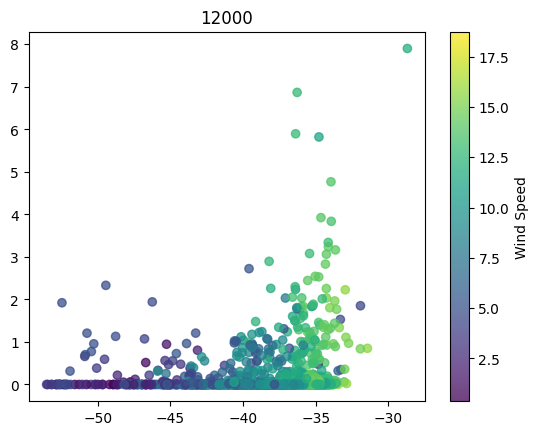

In [34]:
df_r = df.copy()
# df_r = df.loc[df['precipitation_GPM']>0.1].copy()
freqs = [500, 1000, 2000, 5000, 8000, 10000, 12000, 15000, 16000]
for fq in freqs[6:7] :
    cbr = plt.scatter(df_r[f'upwards_mean_{fq}'], df_r["precipitation_GPM"], alpha=0.75, cmap='viridis', c=df_r["wind_speed"])  
    plt.colorbar(cbr, label="Wind Speed")
    plt.title(f"{fq}")
    # plt.yscale('log')
    plt.show()

---
# NPZ

In [6]:
npz_df = pd.DataFrame({})

df = pd.read_csv(os.path.join(path, depid, f"{depid}_dive.csv"))
for idx, row in df.iterrows():
    npz = np.load(os.path.join(path, depid, f"dives/acoustic_dive_{(int(row['dive'])):05d}.npz"))
    spectro = npz["spectro"]
    depth = npz["depth"]
    mask = depth > 10
    spectro = spectro[mask]

    # INTERPOLATION LINEAIRE avec previous ROW dans le df
    if idx < len(df) - 1:
        next_row = df.iloc[idx + 1]
        precip_values = np.linspace(row["precipitation_GPM"], next_row["precipitation_GPM"], len(spectro))
        wind_values = np.linspace(row["wind_speed"], next_row["wind_speed"], len(spectro))
    else:
        precip_values = np.repeat(row["precipitation_GPM"], len(spectro))
        wind_values = np.repeat(row["wind_speed"], len(spectro))


    new_rows = []
    for i in range(len(spectro)):
        psd1000 = spectro[i][32]
        psd2000 = spectro[i][64]
        psd5000 = spectro[i][160]
        psd8000 = spectro[i][256]
        psd10000 = spectro[i][320]
        psd12000 = spectro[i][384]
        psd15000 = spectro[i][480]

        new_rows.append({
            'psd1000': psd1000,
            'psd2000': psd2000,
            'psd5000': psd5000,
            'psd8000': psd8000,
            'psd10000': psd10000,
            'psd12000': psd12000,
            'psd15000': psd15000,
            'precipitation_GPM' : precip_values[i],
            'wind_speed' : wind_values[i],
        })

    npz_df = pd.concat([npz_df, pd.DataFrame(new_rows)], ignore_index=True)

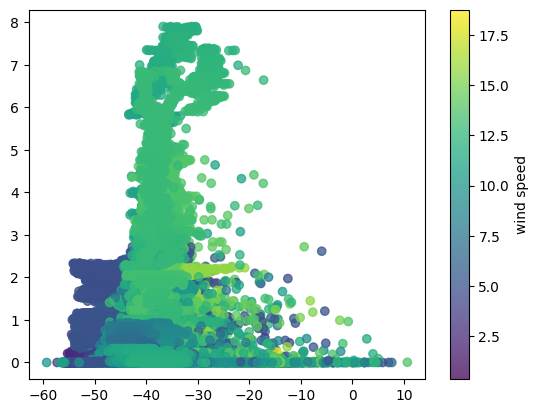

In [47]:
freq = 12000
cbar = plt.scatter(npz_df[f"psd{freq}"], npz_df["precipitation_GPM"], alpha=0.75, c = npz_df["wind_speed"], cmap='viridis')
plt.colorbar(cbar, label="wind speed")
plt.show()

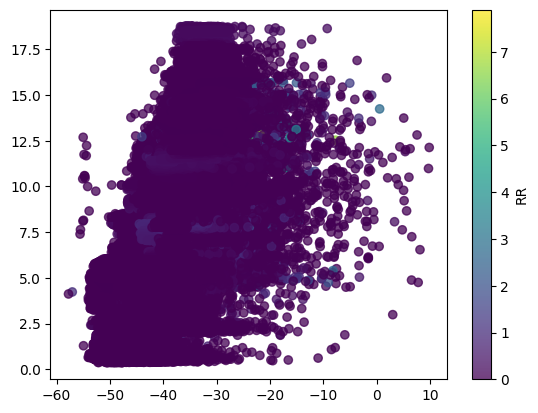

In [48]:
freq = 8000
cbar = plt.scatter(npz_df[f"psd{freq}"], npz_df["wind_speed"], alpha=0.75, c = npz_df["precipitation_GPM"], cmap='viridis')
plt.colorbar(cbar, label="RR")
plt.show()

---
# NPZ moyennés sur 5min

In [40]:
group_index = npz_df.index // 100
npz_df_means = npz_df.groupby(group_index).mean()
print(npz_df_means.shape)
print(npz_df.shape)

(7917, 9)
(791620, 9)


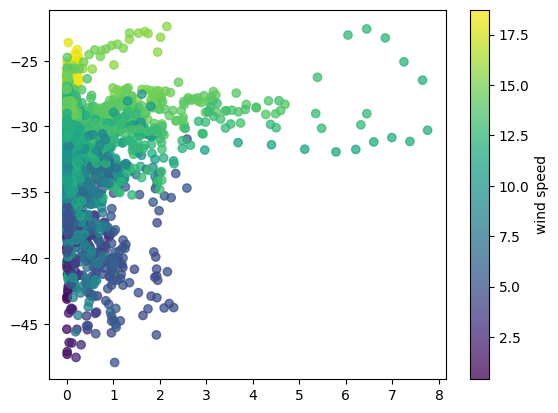

In [53]:
freq = 5000
npz_df_means_r = npz_df_means[npz_df_means["precipitation_GPM"]>0]
cbar = plt.scatter(npz_df_means_r["precipitation_GPM"],npz_df_means_r[f"psd{freq}"], alpha=0.75, c = npz_df_means_r["wind_speed"], cmap='viridis')
plt.colorbar(cbar, label = "wind speed")
plt.show()

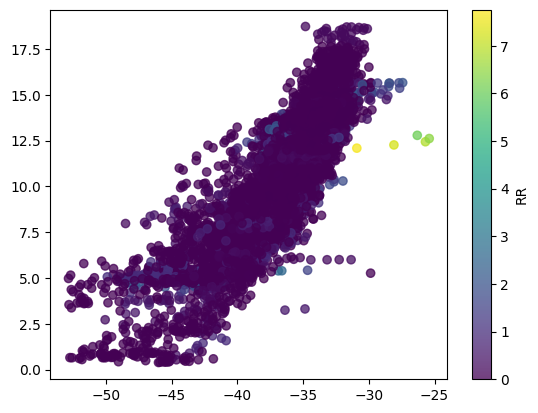

In [42]:
freq = 8000
cbar = plt.scatter(npz_df_means[f"psd{freq}"], npz_df_means["wind_speed"], alpha=0.75, c = npz_df_means["precipitation_GPM"], cmap='viridis')
plt.colorbar(cbar, label="RR")
plt.show()